# JamUNet model trained with the spatial dataset - training and validation

This notebook was used for training and validating the model.

In [48]:
# move to root directory
# %cd ..


%cd /workspace/jamunet-morpho-braided-main

/workspace/jamunet-morpho-braided-main


In [49]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# import modules 
import numpy as np
import torch
import joblib
import copy

from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from model.train_eval import * 
from preprocessing.dataset_generation import create_full_dataset, create_datasets
# from preprocessing.data_normalization import *
from postprocessing.save_results import *
from postprocessing.plot_results import *
from torchsummary import summary

# enable interactive widgets in Jupyter Notebook
%matplotlib inline
# %matplotlib widget



In [4]:
from torch.utils.cpp_extension import CUDA_HOME
print(CUDA_HOME)  # Should point to your Conda environment


/usr/local/cuda


In [5]:
# set the device where operations are performed
# if only one GPU is present you might need to remove the index "0" 
# torch.device('cuda:0') --> torch.device('cuda') / torch.cuda.get_device_name(0) --> torch.cuda.get_device_name() 

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    
print(f'Using device: {device}')

CUDA Device Count:  1
CUDA Device Name:  NVIDIA A40
Using device: cuda:0


In [6]:
## Set seeds to 0 for reproducibility
import random

# Set a seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False    # Disables auto-tuning for performance

set_seed(42)  # Replace 42 with your seed value

In [7]:
# set common keys required for functions

train = 'training'
val = 'validation'
test = 'testing'

In [123]:
# load all datasets

# by default March images are used - if another month is used change the number (available months: 1-4)
dataset_path = r'data/satellite/dataset_month3' 

dtype=torch.float32

train_set = create_full_dataset(train, dir_folders=dataset_path, device=device, dtype=dtype)
val_set = create_full_dataset(val, dir_folders=dataset_path, device=device, dtype=dtype)
test_set = create_full_dataset(test, dir_folders=dataset_path, device=device, dtype=dtype)


In [124]:
print(f'Training dataset samples: {len(train_set)},\n\
Validation dataset samples: {len(val_set)},\n\
Testing dataset samples: {len(test_set)}')
# To check the shape of each tensor in the TensorDataset
for i, tensor in enumerate(train_set.tensors):
    print(f"Tensor {i} shape: {tensor.shape}")

Training dataset samples: 546,
Validation dataset samples: 20,
Testing dataset samples: 20
Tensor 0 shape: torch.Size([546, 4, 1000, 500])
Tensor 1 shape: torch.Size([546, 1000, 500])


In [125]:
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Allocated memory: 11.46 GB
Cached memory: 22.68 GB


In [126]:
# load JamUNet architecture

from model.st_unet.st_unet import *

n_channels = train_set[0][0].shape[0]
n_classes = 1
init_hid_dim = 8
kernel_size = 3
pooling = 'max'

set_seed(42)
generator = torch.Generator().manual_seed(42)

model = UNet3D(n_channels=n_channels, n_classes=n_classes, init_hid_dim=init_hid_dim, kernel_size=kernel_size,          #1
               pooling=pooling, bilinear=False, drop_channels=False ,seed=42)

# model = UNet3D_full(in_channels=1, out_channels=1, init_features=8, temporal=3, seed=42)                              #2
# model = UNet2D(in_channels=4, out_channels=1, init_features=8, seed=42)                                                 #3 (BCE), #14 (Dice)
# model = UNet_semi3D(in_channels=1, out_channels=1, init_features=8, seed=42)                                          #4 & #7
# model = UNet_semi3D_drop(in_channels=1, out_channels=1, init_features=8, seed=42, dropout_rate=0.1)                   #5 BCE, #17 Dice  
# model = UNet_semi3D_shallow8(in_channels=1, out_channels=1, init_features=8, seed=42)                                 #6, #15 BCE, #16 Dice
# model = UNet_semi3D_4_8_resBN_Dice_drop(in_channels=1, out_channels=1, init_features=8, seed=42, dropout_rate=0.1)    #10 & #11 & 12
# model = UNet_semi3D_resBN_3_8(in_channels=1, out_channels=1, init_features=8, seed=42)                                #8, if init_features set on 16 => #9 & #13

In [114]:
# print model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model
model.to(device)

UNet2D(
  (encoder1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, s

In [122]:
# print total number of parameters and model size

num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters:.2e}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 5.23e+05
Model size: 1.99 MB


**<span style="color:red">Attention!</span>** 
\
Since it is not needed to scale and normalize the dataset (see above), the input for the Data Loader are not the normalized datasets.
\
If normalization is performed, the normalized datasets become the inputs to the model.

In [23]:
# hyperparameters
learning_rate = 0.05
batch_size = 16
num_epochs = 300
water_threshold = 0.5
physics = False    # no physics-induced loss terms in the training loss if False
alpha_er = 1e-4    # needed only if physics=True
alpha_dep = 1e-4   # needed only if physics=True

# optimizer to train the model with backpropagation
set_seed(42)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# scheduler for decreasing the learning rate 
# every tot epochs (step_size) with given factor (gamma)
step_size = 15     # set to None to remove the scheduler
gamma = 0.75       # set to None to remove the scheduler
if (step_size and gamma) is not None:
    scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)

# dataloaders to input data to the model in batches -- see note above if normalization is performed

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=generator) 
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, generator=generator)


In [24]:
class EarlyStopping:
    def __init__(self, patience=25, delta=0, save_path="best_model.pth"):
        """
        Early stopping to stop training when validation loss does not improve.

        Args:
            patience (int): How many epochs to wait after the last improvement in the monitored metric (validation loss).
            delta (float): Minimum change in validation loss to qualify as an improvement.
            save_path (str): Path to save the best model weights.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """
        Saves the best model's weights to a file when validation loss improves.
        """
        print(f"Validation loss decreased ({-self.best_score:.6f} -> {-val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.save_path)
        self.best_model = copy.deepcopy(model)

In [25]:
# initialize training, validation losses and metrics
train_losses, val_losses = [], []
accuracies, precisions, recalls, f1_scores, csi_scores = [], [], [], [], []

# set classification loss - possible options: 'Dice', 'BCE', 'BCE_Logits', and 'Focal'
loss_f = 'Dice' 

# set regression loss for physics-induced terms
# possible options: 'Huber', 'RMSE', and 'MAE'
loss_er_dep = 'Huber'

early_stopping = EarlyStopping(patience=20, delta=0, save_path="best_model.pth")

for epoch in range(1, num_epochs + 1):
    set_seed(42)

    # Update learning rate
    if (step_size and gamma) is not None:
        scheduler.step()  # Update the learning rate
    
    # Model training
    train_loss = training_unet(
        model, train_loader, optimizer, water_threshold=water_threshold, 
        device=device, loss_f=loss_f, physics=physics, alpha_er=alpha_er, 
        alpha_dep=alpha_dep, loss_er_dep=loss_er_dep
    )


    # Validation - Disable gradient calculations
    with torch.no_grad():
        val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_csi_score = validation_unet(
            model, val_loader, device=device, loss_f=loss_f, water_threshold=water_threshold
        )
    
    # Save model with the best validation loss
    if epoch == 1:
        best_loss = val_loss
        best_recall = val_recall
    
    if val_loss <= best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0
    
    # Save model with max recall
    if val_recall >= best_recall:
        best_model_recall = copy.deepcopy(model)
        best_recall = val_recall
        best_epoch = epoch
        count = 0

    # Store losses and metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)
    precisions.append(val_precision)
    recalls.append(val_recall)
    f1_scores.append(val_f1_score)
    csi_scores.append(val_csi_score)
    count += 1

    # Check if early stopping should be triggered
    early_stopping(val_loss, model)

    # Break training loop if early stopping is triggered
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | " +
              f"Training loss: {train_loss:.2e}, Validation loss: {val_loss:.2e}, Best validation loss: {best_loss:.2e} " + 
              f" | Metrics: Accuracy: {val_accuracy:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f},\
 F1-score: {val_f1_score:.3f}, CSI-score: {val_csi_score:.3f}, Best recall: {best_recall:.3f}")
        if (step_size and gamma) is not None:
            print(f'Current learning rate: {scheduler.get_last_lr()[0]}')


Validation loss decreased (0.391124 -> -0.391124). Saving model...
Epoch: 1 | Training loss: 4.02e-01, Validation loss: 3.91e-01, Best validation loss: 3.91e-01  | Metrics: Accuracy: 0.876, Precision: 0.454, Recall: 0.923, F1-score: 0.609, CSI-score: 0.438, Best recall: 0.923
Current learning rate: 0.05
Validation loss decreased (0.328967 -> -0.328967). Saving model...
Epoch: 2 | Training loss: 3.50e-01, Validation loss: 3.29e-01, Best validation loss: 3.29e-01  | Metrics: Accuracy: 0.920, Precision: 0.590, Recall: 0.778, F1-score: 0.671, CSI-score: 0.505, Best recall: 0.923
Current learning rate: 0.05
EarlyStopping counter: 1 out of 20
Epoch: 3 | Training loss: 3.48e-01, Validation loss: 3.33e-01, Best validation loss: 3.29e-01  | Metrics: Accuracy: 0.913, Precision: 0.559, Recall: 0.828, F1-score: 0.667, CSI-score: 0.500, Best recall: 0.923
Current learning rate: 0.05
Validation loss decreased (0.328658 -> -0.328658). Saving model...
Epoch: 4 | Training loss: 3.47e-01, Validation los

In [41]:
metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]

In [42]:
# store training and validation losses and metrics to be stored in a .csv file for later postprocessing
# always check the dataset month key
# 
save_losses_metrics(train_losses, val_losses, metrics, 'spatial', model, 3, init_hid_dim, 
                    kernel_size, pooling, learning_rate, step_size, gamma, batch_size, num_epochs, 
                    water_threshold, physics, alpha_er, alpha_dep, dir_output=r'model/losses_metrics')

model/losses_metrics/UNet3D_spatial_losses&metrics_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_300epochs_0.5wthr.csv


**<span style="color:red">Attention!</span>** 
\
Always remember to rename the <code>save_path</code> file before running the whole notebook to avoid overwrting it.

In [43]:
# save model with min validation loss
# always check the dataset month key

save_model_path(best_model, 'spatial', 'loss', 3, init_hid_dim, kernel_size, pooling, learning_rate, 
                step_size, gamma, batch_size, num_epochs, water_threshold) 

model/models_trained/UNet3D_bloss_spatial_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_300epochs_0.5wthr.pth


In [44]:
# save model with max recall
# always check the dataset month key

save_model_path(best_model_recall, 'spatial', 'recall', 3, init_hid_dim, kernel_size, pooling, learning_rate, 
                step_size, gamma, batch_size, num_epochs, water_threshold) 

model/models_trained/UNet3D_brecall_spatial_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_300epochs_0.5wthr.pth


In [45]:
# test the min loss model - average loss and metrics

model_loss = copy.deepcopy(best_model)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_loss, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation loss:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation loss:

Dice loss:          2.619e-01
Accuracy:          0.932
Precision:         0.661
Recall:            0.836
F1 score:          0.738
CSI score:         0.585


In [46]:
# test the max recall model - average loss and metrics

model_recall = copy.deepcopy(best_model_recall)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_recall, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation recall:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation recall:

Dice loss:          3.612e-01
Accuracy:          0.878
Precision:         0.484
Recall:            0.938
F1 score:          0.639
CSI score:         0.469


ATTENTION: the argument `save_name` is not specified: the plot is not saved.


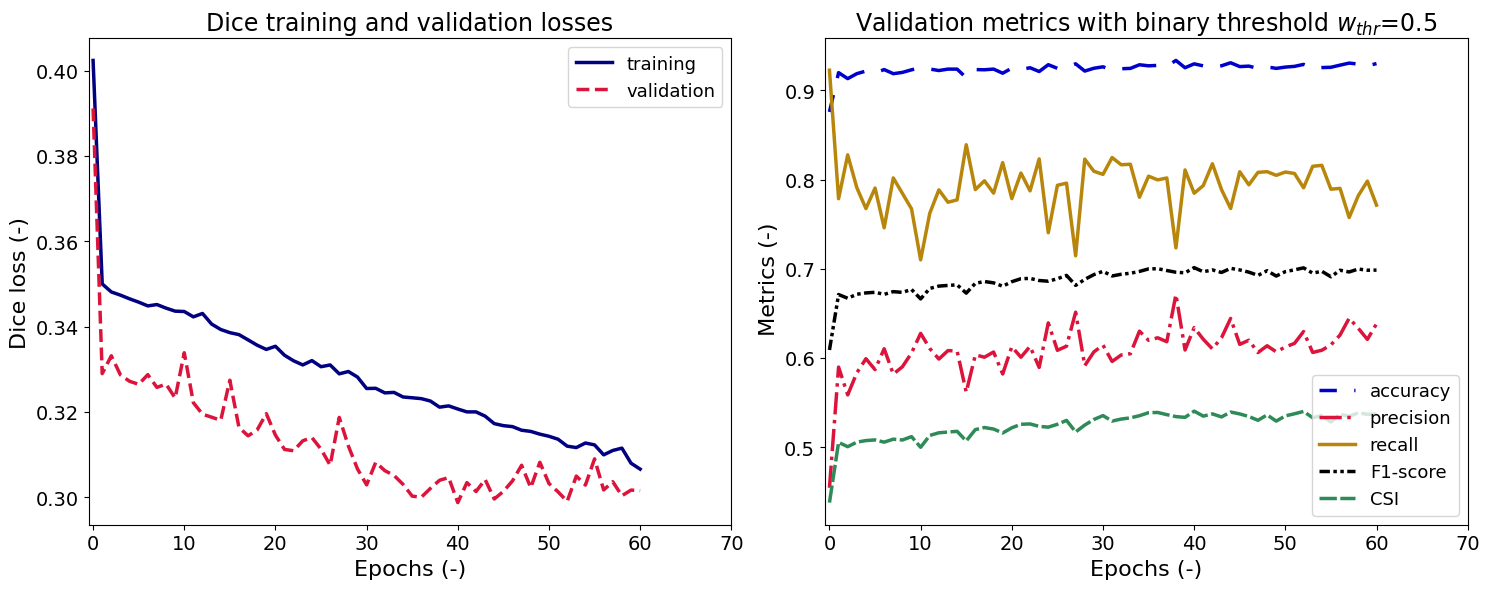

In [47]:
plot_losses_metrics(train_losses, val_losses, metrics, model_recall, loss_f=loss_f)

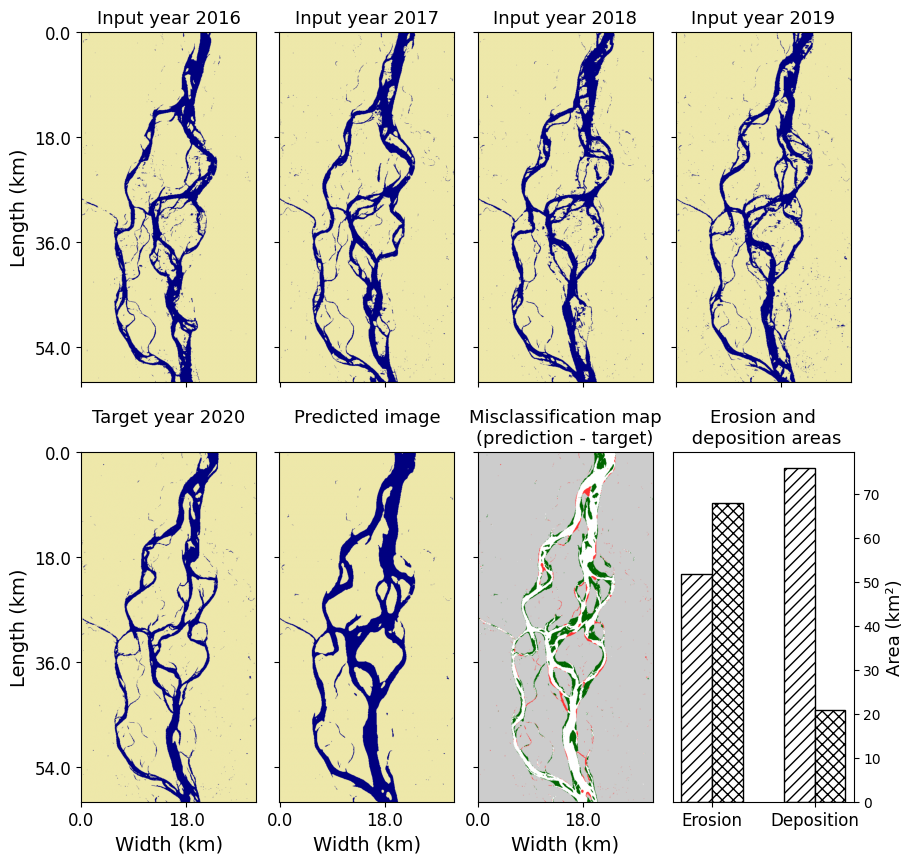

In [127]:
show_evolution_nolegend(18, test_set, model_loss)

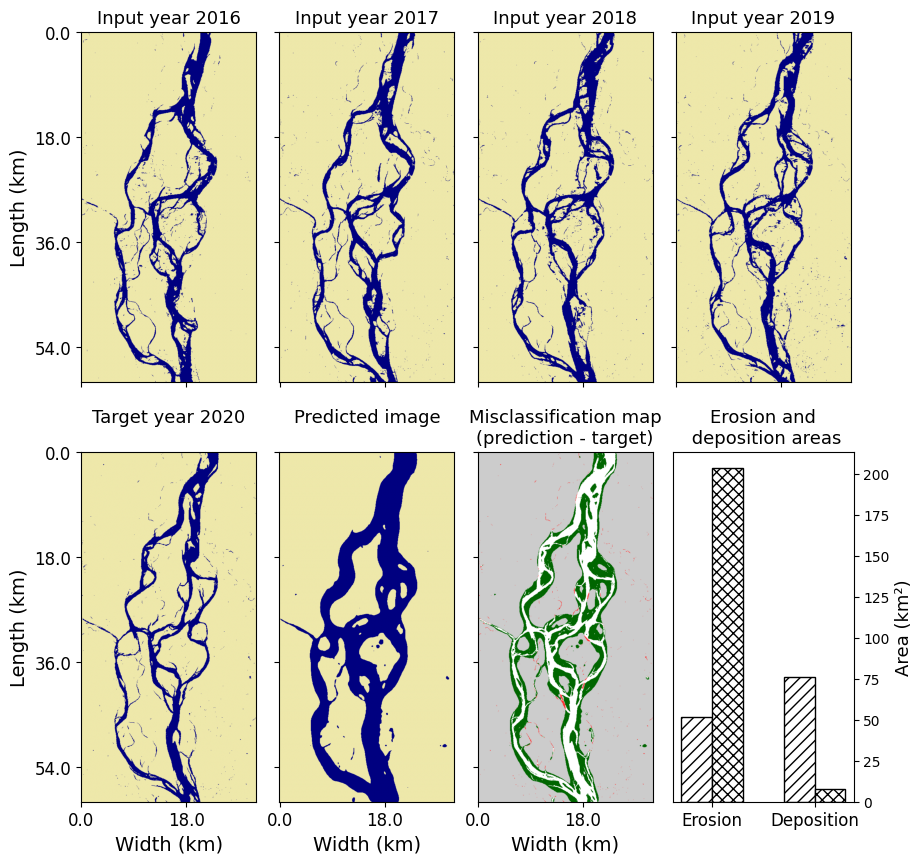

In [128]:
show_evolution_nolegend(18, test_set, model_recall)

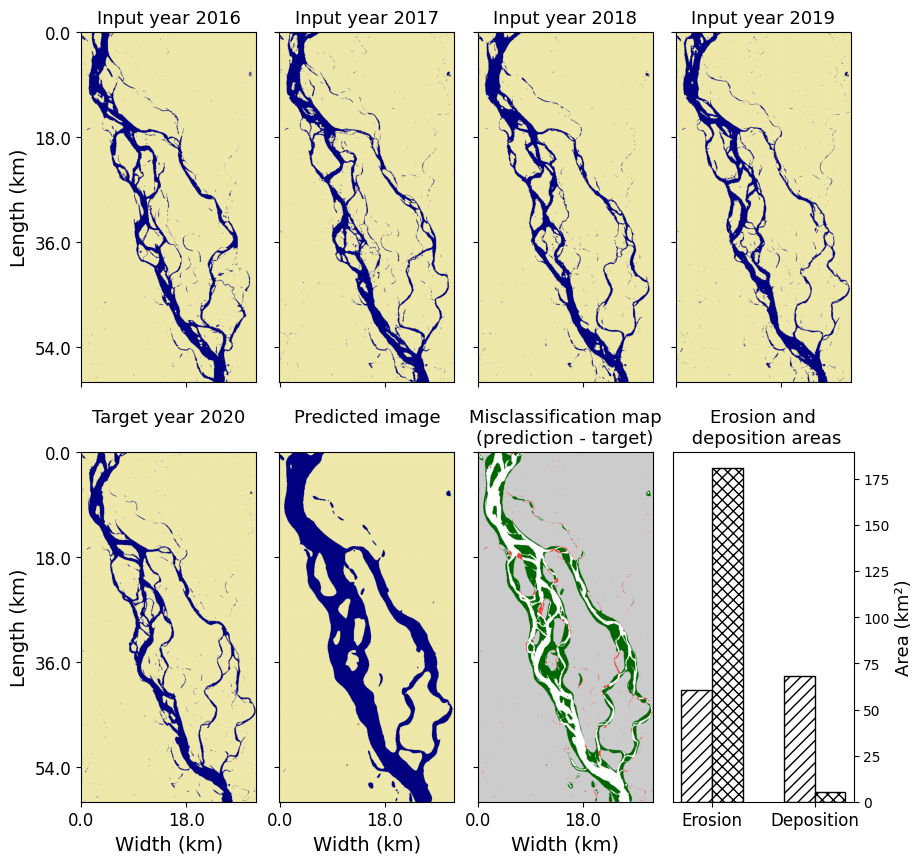

In [129]:
show_evolution_nolegend(18, val_set, model_recall)